# SLU08 - Classification: Learning notebook

In this notebook we will cover the following: 

- Practical Introduction to Classification
- Classification with Logistic Regression
- Using Logistic Regression

Some quick imports to get us started:

In [1]:
import warnings
warnings.filterwarnings(action="ignore")

import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt 
from sklearn.linear_model import LinearRegression, LogisticRegression
# The following is to make some plots along the way 

% matplotlib inline

# Some quick utilts to avoid filling this notebook with support code 
from utils import (get_data_iris, 
                   plot_pair_plots, 
                   plot_line,
                   plot_line_and_annot,
                   draw_logit_curve,
                   get_sepal_vs_petal_width,
                   super_simple_classifier_plot, 
                   linear_separation_plot, 
                   predict_probability_point, 
                   final_classification_plot, 
                   gradient_descent_classification_plot, 
                   plot_maximum_log_likelihood)
% matplotlib inline

In [2]:
df = get_sepal_vs_petal_width()
X, y = get_data_iris()
X_full, y_full = X.copy(), y.copy()

## What is Classification?

So, you just learned about Regression. Now let's tackle a different problem, Classification! You could be asking yourself the following.
> _What is Classification and what are its uses?_

In a nutshell, Classification is the problem of assigning one of a finite set of classes. By being able to accurately classify a data point without knowing its class, allows us to take specific actions towards it. These actions mostly aim to optimize a certain aspect. For instance, an insurance company would like to predict whether a client will churn. If a client is classified as prone to churn, then the company could offer that same client some exclusive discounts or services. Thus, minimizing the client's odds of actually churning.

## Classification Tasks

Depdending on the number of existing classes to classify, the problem can be one of two:
- **Binary Classification**: A classification task with two possible classes. *Eg*: Hot dog classification (Hot Dog / Not Hot Dog)
- **Multiclass Classification**: A classification task with more than two possible classes. *Eg*: Animal classification (Cat / Dog / Bird / ...)

# A Quick Introduction

The concepts behind Classification are relatively simple, but performing accurate and generalizable classification models can get quite complex. There are a lot of different algorithms and approaches for this task, but in this learning unit we will look at the simpler (but still useful!) approaches, and introduce some cool new concepts along the way.

For this notebook, we will use the tiny and famous Iris database:

<img src="https://kasperfred.com/media/posts/creating-your-first-machine-learning-classification-model-in-sklearn/cover2_Zz8UOwj.jpg" style="width: 400px;"/>

Basically, we made a plot for each pairwise feature relationship and distinguished each iris species through color. As you can see, it is actually very useful to look at data visualizations in classification problems. 

Now, we could easily make very complex classification that separates the Species 0 from the other two species by making a separating line where $PETAL\_WIDTH = 0.8$. We will mark all Species 0 iris with the number 0 and the other two as 1. Let's see how the sepal length by petal width plot would look like.

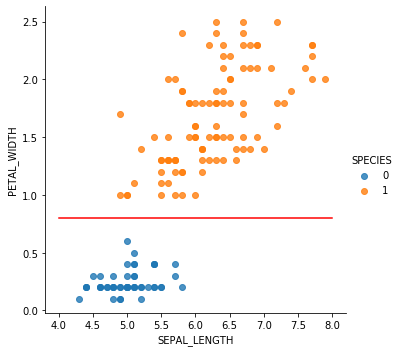

In [3]:
super_simple_classifier_plot(X, y)

Awesome, we just observed a very simple classification approach! However this took a lot of work and it would be great if we could build and use an algorithm that automatically detects the separation lines, like the one we just did, automatically. 


#### Maybe we can use a linear regression? 

Let's try to find a line that separates the two classes, using a simple linear regression. 

In [4]:
df = get_sepal_vs_petal_width()

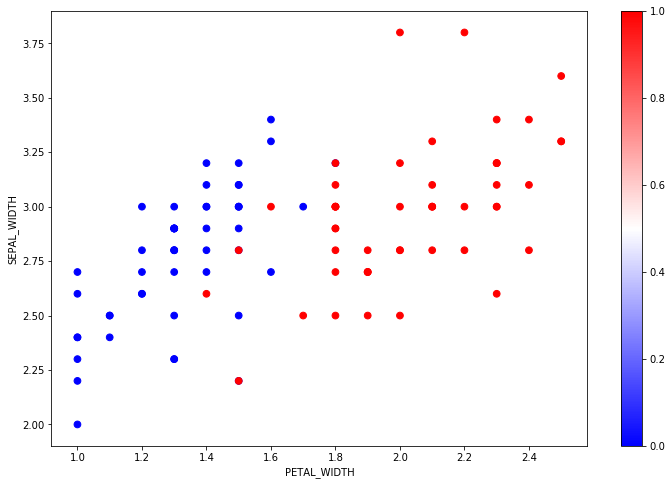

In [5]:
df.plot(kind='scatter', x='PETAL_WIDTH', 
        y='SEPAL_WIDTH', c=df['SPECIES'], 
        cmap='bwr', s=45, figsize=(12, 8), sharex=False, )
plt.show()

Looks like there is a diagonal line that will do a decent job. 

We could try to treat this as a simple regression problem, right? 

It's just that instead of having many different targets, we'd just have 0s and 1s. 

Let's try that: 

In [6]:
# linear regression 
linear_reg = LinearRegression()

# fit (yay scikit!)
features = ['PETAL_WIDTH', 'SEPAL_WIDTH']
target = 'SPECIES'
linear_reg.fit(df[features], df[target])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

And it's fit. So what are our parameters? 

In [7]:
print('y = (%0.2f) x PETAL_WIDTH + (%0.2f) x SEPAL_WIDTH + (%0.2f)' % (linear_reg.coef_[0], 
                                                                 linear_reg.coef_[1], 
                                                                 linear_reg.intercept_))

y = (1.14) x PETAL_WIDTH + (-0.36) x SEPAL_WIDTH + (-0.38)


In [8]:
df['predictions_linreg'] = linear_reg.predict(df[features])

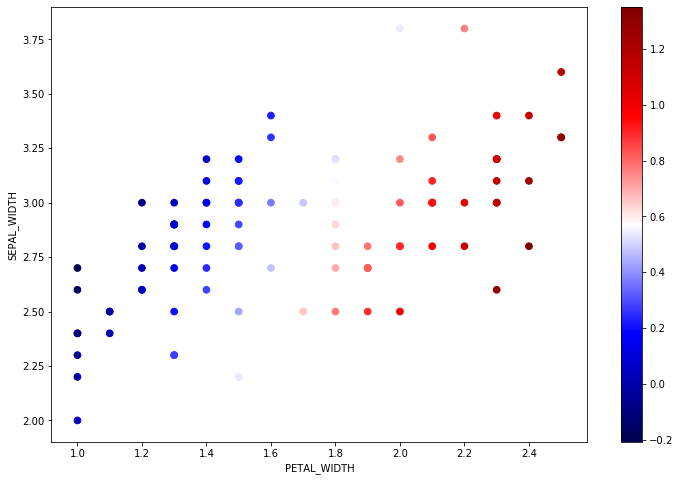

In [9]:
df.plot(kind='scatter', x='PETAL_WIDTH', 
        y='SEPAL_WIDTH', c=df['predictions_linreg'], 
        cmap='seismic', s=45, figsize=(12, 8), sharex=False, );

Not bad! So if we want to figure out where our line is, we could simply say it's where our linear regression marks 0.5, right? 

We are saying that 
$$ y = \beta_0 + \beta_1 * PetalWidth + \beta_2 * SepalWidth  $$

So if we can minimize this error, in a clever way, we will find the best $\beta_1$ and $\beta_2$. Cool. 

Separation line: 

In [10]:
print('(%0.2f) + (%0.2f) x PETAL_WIDTH + (%0.2f) x SEPAL_WIDTH = 0.5' % (linear_reg.intercept_,
                                                                         linear_reg.coef_[0], 
                                                                         linear_reg.coef_[1]))

(-0.38) + (1.14) x PETAL_WIDTH + (-0.36) x SEPAL_WIDTH = 0.5


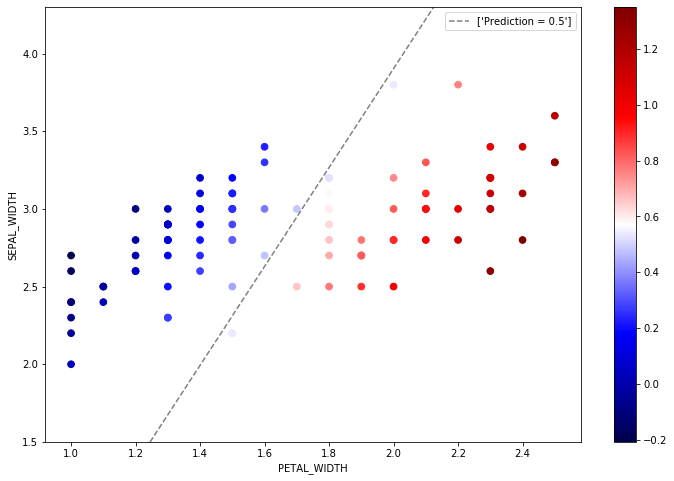

In [11]:
plot_line(df, x='PETAL_WIDTH', y='SEPAL_WIDTH', c=df['predictions_linreg'], linear_reg=linear_reg)

So It looks as if we could (kind of) use this for classification. There are, however, a number of problems with this: 

- Our model doesn't have any concept of probability. If we just use the line, something is either _"definitely 0"_ or _"definitely 1"_, and we don't like that. 

- If we try to use the colors to indicate probability, they are way too conservative. Some of those reds are clearly red, yet they get given numbers such as 0.6, or 0.7.

- Also, we don't like the fact that it is predicting "-0.2" and "1.3". What does that even mean? 

### What we would like 

What we would like would be for it to be "50-50" on the border, and then to start gaining confidence as the margin increases. In other words, we'd like it to return _"the probabilty of being 1."_

Something like... this: 

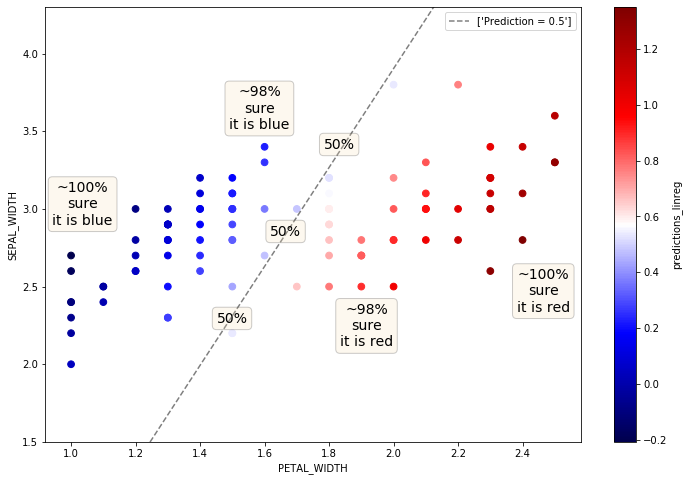

In [12]:
plot_line_and_annot(df, linear_reg)

So as we move away from the border, we'd get quite confident pretty fast. This curve would look something like this:  

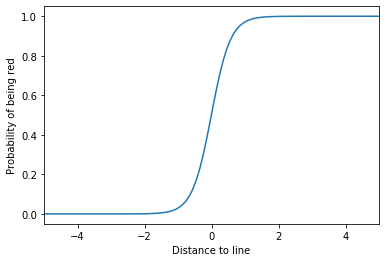

In [13]:
draw_logit_curve(df)

 That is where Logistic Regression comes in!

<img src="https://image.ibb.co/fbBhEH/download.jpg" style="width: 400px;"/>

# Logistic Regression

Despite its name, the [Logistic Regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) is a classification algorithm. 

The idea is very simple: you have a linear model, and then apply a logit or sigmoid function. 

Visually, this it the difference between logistic regression and linear regression: 
Let's see what this means: 

![](data/logit.jpg)

Mathematically, this was linear regression (slightly simplified): 

$$ y = \beta_0 + \beta_1 * PetalWidth + \beta_2 * SepalWidth $$

And with logistic regression, we have the following: 

$$ y = \frac{1}{1 + e^{-(\beta_0 + \beta_1 * PetalWidth + \beta_2 * SepalWidth)}} $$

Which is called the sigmoid or logit function. This may look intimidating, but it's actually quite simple. The "weird" looking bit is just the linear regression, right? 

$$ y = \frac{1}{1 + e^{-(Cool\ this\ is\ just\ the\ linear\ regression!)}} $$

The "weird" looking bit can be simply defined as $z$:

$$ y = \frac{1}{1 + e^{-z}} $$

## Probability Estimation

You should be asking yourself the following:

> _But how does Logistic Regression use this linear boundary to quantify the probability of a data point belonging to a certain class?_

Well...
<img src="https://pics.me.me/its-magic-memegen-com-19255903.png" style="width: 400px;"/>



Not really, once the model is trained, the boundary function is quite simple! Let $x_1$ and $x_2$ be two variables, such as $SEPAL\_LENGTH$ and $PETAL\_WIDTH$ as we've been using until now. Also, let $\hat{p}$ be the probability of an event or class. It should be noted again that Logistic Regression can only classify between two classes at a time, a positive class $+$ and negative class $-$. For example, the $-$ and $+$ classes could represent species 0 or 1, respectively. The resulting function is as follows:

$$ln\left ( \frac{\hat{p}}{1-\hat{p}} \right ) = \beta_0 + \beta_1 x_1 + \beta_2 x_2$$

Consider a point $(a, b)$. Inputting the values of $x_1$ and $x_2$ into the boundary function, we will get its output $\beta_0 + \beta_1 a + \beta_2 b$. Now depending on the location of $(a, b)$, there are three possibilities to consider:

* $(a, b)$ lies in the region defined by points of the $+$ class. As a result, $\beta_0 + \beta_1 a + \beta_2 b$ will be positive, lying somewhere in $(0, \infty)$. Mathematically, the higher the magnitude of this value, the greater is the distance between the point and the boundary. Intuitively speaking, the greater is the probability that $(a, b)$ belongs to the $+$ class. Therefore, $\hat{p}$ will lie in $(0.5, 1]$. Let's try this out for a classification task with Logistic Regression between species 0 and 1 with variables $SEPAL\_LENGTH$ and $PETAL\_WIDTH$. By observation, we'll choose point $(5,1)$, but you can change it to another one!

In [14]:
predict_probability_point(X_full, y_full, (5,1))

The probability of point (5.0,1.0) belonging to Species 1 is 0.79


* $(a, b)$ lies in the region defined by points of the $-$ class. Now, $\beta_0 + \beta_1 a + \beta_2 b$ will be negative, lying in $(-\infty, 0)$. But like in the positive case, higher the absolute value of the function output, greater the probability that $(a, b)$ belongs to the $-$ class. $\hat{p}$ will now lie in $[0, 0.5)$. Let's choose such a point for the same classification task as before! By observation, we'll choose point $(5,0.2)$, but you can change it to another one!

In [15]:
predict_probability_point(X_full, y_full, (5,0.2))

The probability of point (5.0,0.2) belonging to Species 1 is 0.10


* $(a, b)$ lies ON the decision boundary. In this case, $\beta_0 + \beta_1 a + \beta_2 b = 0$. This means that our model cannot really say whether $(a, b)$ belongs to the $+$ or $-$ class. As a result, $\hat{p}$ will be exactly $0.5$. Such a point would be $(5,0.7)$.

In [16]:
predict_probability_point(X_full, y_full, (5,0.7))

The probability of point (5.0,0.7) belonging to Species 1 is 0.50


<img src="https://i.imgflip.com/286p5c.jpg" style="width: 400px;"/>

On the other side, the $\frac{\hat{p}}{1-\hat{p}}$ function is called the the $odds \ ratio$ function $OR(X)$, which is essentially the ratio of the probability of an observation belonging to a certain class vs. it not belonging. Probability and odds convey the exact same information, but as $\hat{p}$ ranges $[0, 1]$, $OR(X)$ ranges $(0, \infty)$.

That was enough theory. Imagine that we want to classify iris flowers between species 0 and 1 by only using $SEPAL\_LENGTH$ and $PETAL\_WIDTH$ as $x_1$ and $x_2$, respectively. Suppose we already have a logistic regression model trained which coefficients are:

$$\beta_0 = -0.92210397 \\ \beta_1 = -0.4441176 \\ \beta_2 = 4.47663504$$ 

If we want to obtain the probability $\hat{p}$ of a sample $(5,1)$ belonging to class $+$ we do the following.  

* Compute the boundary function $\beta_0 + \beta_1 a + \beta_2 b$ which output we will simply call $z$;

In [17]:
z = -0.92210397 + -0.4441176 * 5 + 4.47663504 * 1
print(z)

1.3339430699999992


* Compute the $odds \ ratio$, through $OR(X) = e^z$;

In [18]:
OR = np.exp(z)
print(OR)

3.7959817384457244


* Compute $\hat{p}$ = $\frac{e^z}{1 + e^z} = \frac{1}{1 + e^{-z}}$, called the $logistic \ function$.

In [19]:
p = OR / (1 + OR)
print(p)

0.791492116831104


This was exactly what the $predict\_probability\_point$ function did for point $(5,1)$ previously!

## Defining a Probability Threshold to Perform Classification

Now we know how Logistic Regression estimates class probabilities $\hat{p}$, but how do we define if an iris plant belongs to the + or - class? 

For this binary classification task we can simply say that if for a given iris plant $\hat{p} >= threshold$ then it belongs to the + class else it belongs to the - class. By default, binary classification algorithms use $threshold=0.5$.

However, $threshold$ can be modified to have values between $[0, 1]$. This can be useful in cases where one of the classes has many fewer data samples compared to the other. Such problems are said to have a class imbalance, which is not the case for this problem.

Let's try to classify between species 0 and 1 using several different $threshold$ values and see what happens.

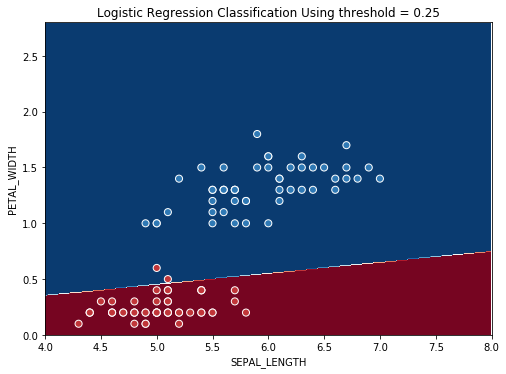

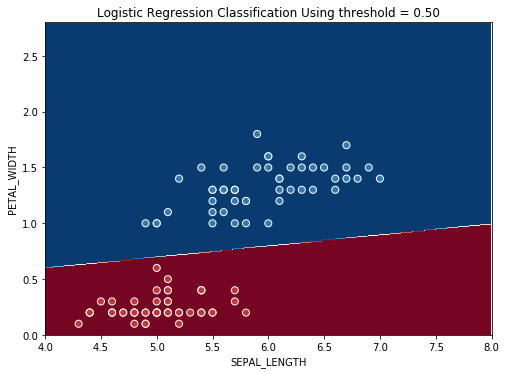

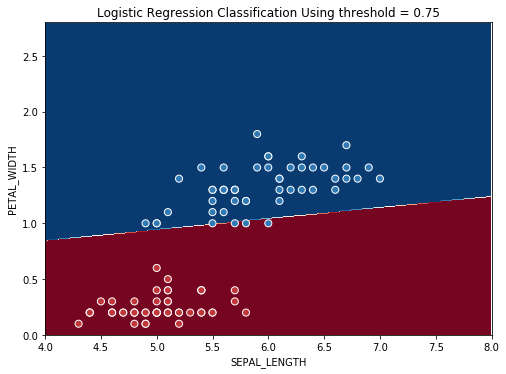

In [20]:
final_classification_plot(X_full, y_full, threshold_values=[0.25, 0.5, 0.75])

We can see how the results vary by modifying the threshold and that the results are the best when $threshold=0.5$ for this particular case.

Now that we understood how to use the logistic regression formula to obtain probabilities and defining thresholds, we can now learn how to train the model and obtain the coefficients and intercept. That is where cost functions come in!

## Cost Function

In machine learning, the focus is on learning from data, right? And how can a model learn from data like an individual can learn to play an instrument? Through minimizing a cost function! An aspiring new musician would like to minimize the number of times he plays out of tune, which would be his cost function. He will learn how to play the instrument correctly through trial and error as well as feedback, thus minimizing his cost function. 

A machine learning model does just the same, it aims to minimize a cost function which is a measure of how wrong it is in terms of its ability to estimate the relationship between $X$ and $Y$. Therefore, the aim of a machine learning model is to find the coefficients, parameters, weights or a structure that minimizes a cost function, which it will iteratively do.

<img src="https://i.imgflip.com/288yvb.jpg" style="width: 400px;"/>

## Maximum Log-Likelihood

Unfortunately, we shouldn't use the same cost function Mean Squared Error as we did for linear regression. Why? Because our prediction function is non-linear (due to the logistic function). Squaring this prediction as we do in MSE results in a non-convex function with many local minima. If our cost function has many local minima, gradient descent may not find the optimal global minima! So let's just trust in our old friend Boromir.

<img src="https://i.imgflip.com/289uki.jpg" style="width: 400px;"/>

Instead of Mean Squared Error, we use a cost function called Maximum Likelihood, adapted to log-likelihood ($i.e.$ Maximum Log-Likelihood). For a dataset with $N$ observations, $y_N$ true labels and $\hat{p}_N$ predictions it is defined as follows:

$$H_{\hat{p}}(y) = - \frac{1}{N}\sum_{i=1}^{N} \left [{ y_i \ \log(\hat{p}_i) + (1-y_i) \ \log (1-\hat{p}_i)} \right ]$$

It's better to first observe its behaviour. Let's plot two charts with the predicted probability $\hat{p}$ going from $0$ to $1$, but for two different real labels $y$.

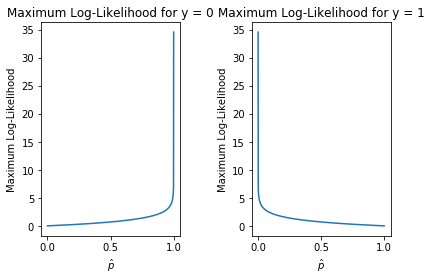

In [21]:
plot_maximum_log_likelihood()

Basically, the key thing to note is that the cost function penalizes confident and wrong predictions more than it rewards confident and right predictions! Now that we know the cost function that is mostly used for Logistic Regression let's now look at how a loss function can be minimized.

## Optimization: Gradient Descent

Now that you know the concept behind the cost function, you may be asking to yourself how we can minimize it. That is where gradient descent comes in! It is one of the most efficient optimization algorithms which attempts to find a local or global minima of a function. 

Gradient descent allows a machine learning model to learn the gradient (*aka* the direction) that the model should take in order to reduce errors and thus minimizing the cost function. 

In a simplified way, gradient descent evaluates a point, and finds the "direction" where the cost function goes down the most. The easiest metaphor is a river going down a mountain. It will always go down the "steepest" possible route. 

![](https://ml-cheatsheet.readthedocs.io/en/latest/_images/gradient_descent.png)

In the Logistic Regression example, direction refers to how the model parameters $\beta_0$, $\beta_1$ and $\beta_2$ should be tweaked or corrected as to reduce the cost function. As the model iterates, it tends to a minimum where any further changes to the parameters produces little or any changes in the cost function. In such a case, it is said that it converged. We have an example below where we can see gradient descent in action.

<img src="https://cdn-images-1.medium.com/max/1600/1*ZmzSnV6xluGa42wtU7KYVA.gif" style="width: 400px;"/>

An alternative to gradient descent would be brute forcing a potentially infinite combination of parameters until the set of parameters that minimizes the cost is found. However, this is not feasible and, thus, gradient descent enables the learning process to make corrective updates to the learned estimates that move the model towards an optimal combination of parameters.

How interesting would it be to actually observe Logistic Regression do gradient descent and change its decision boundary? Let's do just that! Let's observe 25 iterations of gradient descent.

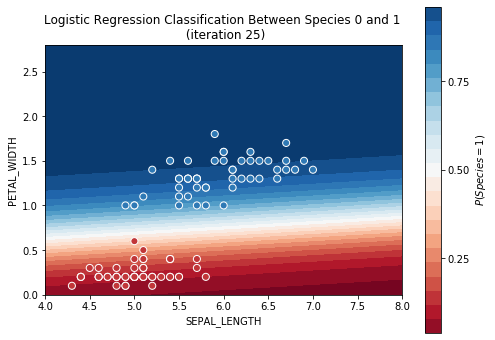

<Figure size 576x432 with 0 Axes>

In [22]:
# this cell takes a bit of time to run, but is pretty 
gradient_descent_classification_plot(X_full, y_full, 25)

We can see that the decision boundary starts quite wide and somewhat horizontal and then starts to shrink and move between the two iris species!

Now you should be asking yourself how can you apply gradient descent to modify the model's parameters and minimize the cost function. For that, let's refresh our memory on how we can predict a probability only with an intercept $\beta_0$ and coefficient $\beta_1$. 

$$ \hat{p} = \frac{e^{\beta_0 + \beta_1 x_1}}{1 + e^{\beta_0 + \beta_1 x_1}}$$

This can be further simplified into

$$ \hat{p} = \frac{1.0}{1.0 + e^{(-(\beta_0 + \beta_1 x_1))}}$$

But wait! We still don't know what Gradient Descent really means! Basically, is it the process of minimizing a function by following the gradients of the cost function. This involves knowing the form of the cost as well as the derivative so that from a given point you know the gradient and can move in that direction, e.g. downhill towards the minimum value.

### Stochastic Gradient Descent

In machine learning, we can use a technique that evaluates and updates the coefficients every iteration called stochastic gradient descent to minimize the error of a model on our training data. The way this optimization algorithm works is that each training instance is shown to the model one at a time. The model makes a prediction for a training instance, the error is calculated and the model is updated in order to reduce the error for the next prediction. This procedure can be used to find the set of coefficients in a model that result in the smallest error for the model on the training data. Each iteration, the coefficients ($\beta$) in machine learning language are updated using the equation:

$$\beta_{t+1} = \beta_t - learning\_rate \frac{\partial H_{\hat{p}}(y)}{\partial \beta_t}$$

which we can simplify to

$$\beta_{t+1} = \beta_t + learning\_rate \left [(y - \hat{p}) \ \hat{p} \ (1 - \hat{p}) \ x \right]$$

where $learning\_rate$ is a learning rate that you must configure (*e.g*. 0.1). You think of learning rate as how big a step you want to take in each iteration. Small steps converge slower, while big steps are faster but might not converge. 

Exceptionally, the intercept is updated without an observation as it is not associated with a specific observation.

$$\beta_{0(t+1)} = \beta_{0(t)} - learning\_rate \frac{\partial H_{\hat{p}}(y)}{\partial \beta_{0(t)}}$$

which we can also simplify to

$$\beta_{0(t+1)} = \beta_{0(t)} + learning\_rate \left [(y - \hat{p}) \ \hat{p} \ (1 - \hat{p})\right]$$

We can see that each sample has a big impact on the convergence. What happens if the data is sorted by class or in this case species? In the beginning the algorithm would only use data from Species 0 plants which could make it converge before even using data from other species! This is why we should always shuffle the data prior performing Stochastic. Gradient Descent

### Batch Gradient Descent

Stochastic gradient descent can be very noisy which makes it difficult to converge properly to the global minima. This happens because the model parameters are updated with each individual sample. A simple approach that reduces the noise could be to average the gradient over all training samples. This approach exists and it is called **Batch Gradient Descent**. The downside of using Batch instead of Stochastic is that it is slower. We can update a specific coefficient ($\beta$) as follows:

$$\beta_{t+1} = \beta_t + learning\_rate \frac{1}{N} \sum_{i=1}^{N} \left [(y_i - \hat{p}_i) \ \hat{p}_i \ (1 - \hat{p}_i) \ x_i \right]$$

And the intercept:

$$\beta_{0(t+1)} = \beta_{0(t)} + learning\_rate \frac{1}{N} \sum_{i=1}^{N} \left [(y_i - \hat{p}_i) \ \hat{p}_i \ (1 - \hat{p}_i) \right]$$

It should be noted that the formulas were already simplified to leave most of the math out. If you run this iterative process many times, you should obtain the coefficients that converge to a minimum of the cost function and thus, your logistic regression model!

## Normalization

It is crucial that your variables are adjusted between $[0;1]$ (normalized) or standardized so that you can correctly analyse some logistic regression coefficients for your possible future employer. Additionally, it is also important to normalize your data if your algorithm is doing gradient descent which will lead to a much faster convergence. 

To adjust your variables between $[0;1]$, you would apply the following formula:

$$ x_{normalized} = \frac{x - x_{min}}{x_{max} - x_{min}}$$

which is called normalization. It is a simple formula, but Scikit-Learn has this transformation already implemented called `MinMaxScaler`. To do so, you would do the following:

In [23]:
from sklearn.preprocessing import MinMaxScaler

sclr = MinMaxScaler().fit(X_full)
normalized_X = sclr.transform(X_full)

And from then, you could confidently apply Logistic Regression to the normalized data and interpret the resulting model.

## [Sklearn Logistic Regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

We now know most of what we need to know about Logistic Regression. If you understood everything until know then you should have an idea of its strengths and weaknesses:
* Strengths: Outputs have a probabilistic interpretation, and can be updated easily with new data using stochastic gradient descent. Additionally, the algorithm can be regularized to avoid overfitting. 
* Weaknesses: Logistic regression tends to underperform when there are multiple or non-linear decision boundaries. They are not flexible enough to naturally capture more complex relationships.

Fortunately, there are already a lot of logistic regression implementations that are already quite computationally efficient. So, there's no need for you to code them from scratch. You can find one of those implementations in sklearn! You can import it this way:

In [24]:
from sklearn.linear_model import LogisticRegression

This implementation can use these optimization methods:
* liblinear: default;
* newton-cg;
* lbfgs; 
* sag;
* saga.

Now that you've loaded the algorithm, you need to first create the classifier object. We will set `random_state` to $0$ just to make sure we obtain the exact same results. 

In [25]:
logit_clf = LogisticRegression(random_state=0)

Cool, now you just created the algorithm object that is ready to learn from some juicy data. Now you have to give it the input data $X$ as well as the corresponding labels $y$ so that it can train and converge to the optimal parameters.

In [26]:
logit_clf.fit(normalized_X, y_full)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

And voilà! You just created your first logistic regression model. Now, it would be interesting to know how good the model is! And we can do so, by checking the percentage of correctly predicted observations on the data by doing the following.

In [27]:
logit_clf.score(normalized_X, y_full)

0.8466666666666667

Oh we were right 84.7% of the time, not bad! What if we want to get the predictions for each sample instead of the score?

In [28]:
preds = logit_clf.predict(normalized_X)
preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2,
       2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Great! These are the `argmax` of the predicted probabilities, in other words, the class with highest predicted probability for ech sample. However, it would be more interesting to obtain and observe the probabilities of each class! We can do it this way.

In [29]:
probas = logit_clf.predict_proba(normalized_X)
probas[:10]

array([[0.8009076 , 0.16869592, 0.03039647],
       [0.71621223, 0.25127721, 0.03251056],
       [0.76068834, 0.2107723 , 0.02853936],
       [0.73566056, 0.23390498, 0.03043445],
       [0.81719564, 0.15389109, 0.02891326],
       [0.83406663, 0.12325521, 0.04267815],
       [0.78734602, 0.18119149, 0.03146249],
       [0.78222304, 0.1863514 , 0.03142556],
       [0.70625051, 0.26455852, 0.02919097],
       [0.73568032, 0.23567669, 0.02864299]])

And then we can do whatever we want with the predicted probabilities!

You may now be legitimately asking... 

> _"Why didn't the classifier just return probability of being 1, instead of making me jump through hoops?"_

![](https://i.imgflip.com/2ntgpm.jpg)

## Multi-Class Classification with Logistic Regression

Let's say that instead of having 2 types of flower, we have 3. 

Notice the SPECIES column: 

In [30]:
df_full = pd.concat([X_full, y_full], axis=1)
display(df_full.sample(5, random_state=50))

,SEPAL_LENGTH,SEPAL_WIDTH,PETAL_LENGTH,PETAL_WIDTH,SPECIES
88,5.6,3.0,4.1,1.3,1
72,6.3,2.5,4.9,1.5,1
20,5.4,3.4,1.7,0.2,0
16,5.4,3.9,1.3,0.4,0
147,6.5,3.0,5.2,2.0,2


Now let's make some predictions with this dataset. Same logic as before. 

In [31]:
# instanciate
logit = LogisticRegression()

# fit 
logit.fit(normalized_X, y_full)

# predict (optional)
predictions = logit.predict(normalized_X)

# predict probabilities (generally what we want)
probability_predictions = logit.predict_proba(normalized_X)

In [32]:
# display the first 5 predicted probabilities 
probability_predictions[0:5]

array([[0.8009076 , 0.16869592, 0.03039647],
       [0.71621223, 0.25127721, 0.03251056],
       [0.76068834, 0.2107723 , 0.02853936],
       [0.73566056, 0.23390498, 0.03043445],
       [0.81719564, 0.15389109, 0.02891326]])

So how do we read this... The first flower can be class 0 or 1, but if very unlikely to be class 2 

In [33]:
probability_predictions[0]

array([0.8009076 , 0.16869592, 0.03039647])

Let's look at another flower, the one at position 50: 

In [34]:
probability_predictions[50]

array([0.09152219, 0.37933835, 0.52913946])

Ok, so this flower: 
- is likely to be of class 2 (53% probability)
- may still be of class 2 (38% probability) 
- is almost certainly not of class 0. 

The algorithm has a lot more arguments that you can change to modify its behaviour as well as other methods that you can explore. Feel free to explore them here: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html